In [1]:
import os, sys, time, copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [4]:
# V = model.voltage(times)
g = 0.1524 * 1e3 # [pA/V]
p1 = 2.26e-4 * 1e3 # [1/s]
p2 = 0.0699 * 1e3  # [1/V]
p3 = 3.45e-5 * 1e3 # [1/s]
p4 = 0.05462 * 1e3 # [1/V]
p5 = 0.0873 * 1e3  # [1/s]
p6 = 8.91e-3 * 1e3 # [1/V]
p7 = 5.15e-3 * 1e3 # [1/s]
p8 = 0.03158 * 1e3 # [1/V]

dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())
t_span

(0, 15.3998)

The protocol is 15.4 s


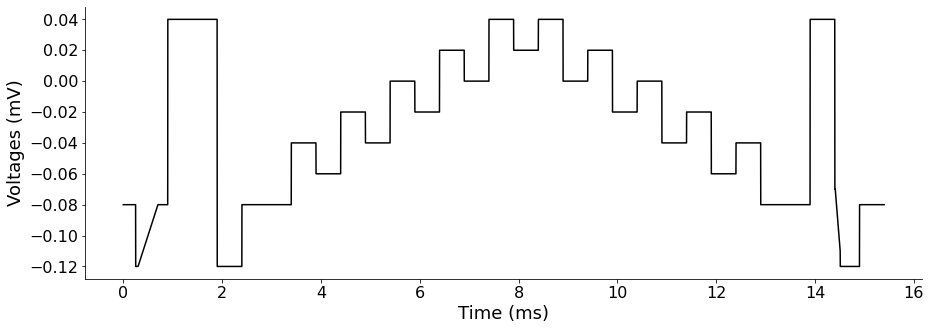

In [5]:
'''
leak_staircase
'''
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

# VC_protocol = vc_protocols_for_myokit.leak_staircase()
VC_protocol = vc_protocols.leak_staircase()

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} s')
VC_protocol.plot_voltage_clamp_protocol(t_eval)

In [6]:
gen_params = {
    'end_time': VC_protocol.get_voltage_change_endpoints()[-1],   
    't_eval' : t_eval, 
    'log_li' : ['ikr.IKr', 'ikr.open', 'ikr.active'],
    'save_log_li' : ['ikr.IKr'],
    'nData' : 5,                         
    # 'dataset_dir' : '../../Dataset/ohara2017_LeemV1',
    'dataset_dir' : f'./kylie2017_hERG_leakstaircase',
    'data_file_name' : 'IKr',
    'window' : 10,
    'step_size' : 5,
}  
# gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
print( gen_params['dataset_dir'] )

sys.path.append(gen_params['dataset_dir'])
from agetdata import get_dataset, get_dataset2

./kylie2017_hERG_leakstaircase


In [7]:
# for i in range(5):
# xs, ys = get_dataset(file_numbers=range(1, 3), multi=True, use_torch=True)

# xs, ys = get_dataset(file_numbers=range(1, 31), window=10, step_size=5, multi=False, use_torch=False, get_raw=False)

xs, ys = get_dataset2(file_numbers=range(71, 73), window=-1, step_size=-1, window_type='avg', noise_sigma=-1, multi=True, torch_tensor=False)  # <-- fast

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1966.39it/s]

--- 3.277097702026367 seconds ---


In [8]:
print(xs.shape, ys.shape)

(200, 2) (200, 9)


In [9]:
dataNo = 100

sol1 = {}
sol1['Time'] = xs[dataNo][0] 
sol1["IKr"] = xs[dataNo][1]
y = ys[dataNo]

# sol1 = pd.DataFrame(data=sol1)
# sol1.head()

In [10]:
sol1["IKr"].shape

(23079,)

In [11]:
y

array([4.45843537e+04, 1.14076460e-04, 1.21300359e+02, 2.53645422e-01,
       7.26793574e+01, 1.37773445e+02, 1.55227485e+01, 1.52328407e+00,
       3.16365081e+01])

In [15]:
start_time = time.time()

# hERG model settings
temperature = 25.0
temperature += 273.15  # in K
fit_seed = '542811797'
withfcap = False

model, p, s = myokit.load("../../../mmt-model-files/kylie-2017-IKr.mmt")    
model.get('phys.T').set_rhs(temperature)
# Set concentration
model.get('potassium.Ko').set_rhs(float(4.0))
model.get('potassium.Ki').set_rhs(float(110.0))

sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1e-3, abs_tol=1e-12, rel_tol=1e-14, vhold=-80e-3)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "kylie2017IKr"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 10.378272771835327 seconds ---


In [16]:
start_time = time.time()

model_params = {                    
    'ikr.g' : y[0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
    'ikr.p1' : y[1],
    'ikr.p2' : y[2],
    'ikr.p3' : y[3],
    'ikr.p4' : y[4],
    'ikr.p5' : y[5],
    'ikr.p6' : y[6],
    'ikr.p7' : y[7],
    'ikr.p8' : y[8],                
} 
sim.set_simulation_params(model_params)                
    
sim.pre_simulate(100, sim_type=1)
# d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=gen_params['log_li'])                           
d = sim.simulate( gen_params['end_time'], log_times=None, extra_log=gen_params['log_li'])                           
              
sol2 = {}
sol2["Time"] = d['engine.time']
sol2["IKr"] = d['ikr.IKr'] #+ np.random.normal(0, 2, d['membrane.i_ion'].shape) # add noise
sol2["open"] = d['ikr.open']
sol2["active"] = d['ikr.open']
sol2["params"] = y
# sol2 = pd.DataFrame(data=sol2)
# sol2.head()
# np.random.normal(0, noise_sigma, current.shape) # add noise
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.24486374855041504 seconds ---


In [17]:
# sol2 = get_currents_with_constant_dt(sol2, window=gen_params['window'], step_size=gen_params['step_size'])

In [18]:
sol2["IKr"].shape

(23079,)

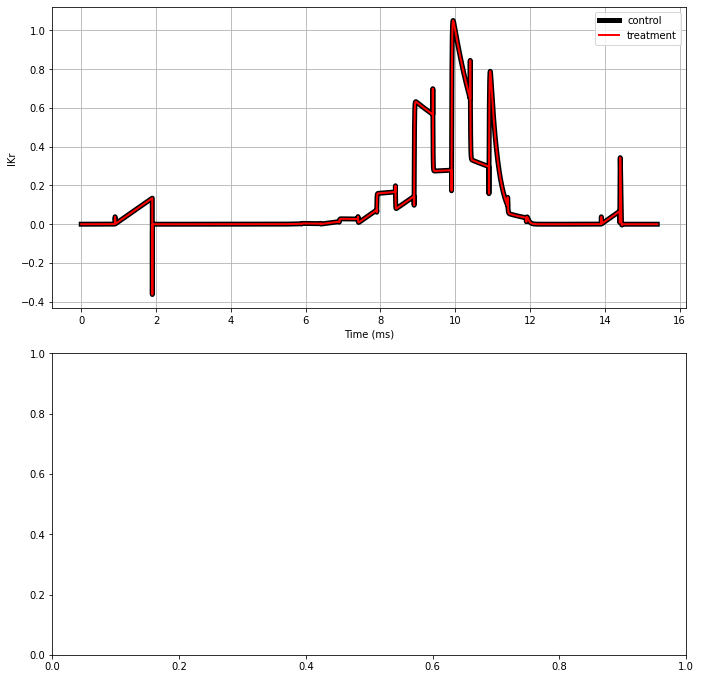

In [19]:
'''
Plot
'''
fig, ax = plt.subplots(2,1, figsize=(10,10))    
# fig.suptitle(sim.name, fontsize=14)
axNo = 0
for name in ['IKr']:    
    # if name!='Time Start' and name!='Time End' and name!='Time Mid':
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[axNo].set_xlabel('Time (ms)')       
    ax[axNo].set_ylabel(f'{name}')      
    ax[axNo].plot( sol1["Time"], sol1[name], label='control', color='k', linewidth=5)     
    ax[axNo].plot( sol2["Time"], sol2[name], label='treatment', color='r', linewidth=2)    
    ax[axNo].legend()
    ax[axNo].grid()
    axNo += 1

# ax[-1].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)